## Model evaluation

This notebook contains the code to compare two models that seem to perform the best in the model training phase.

In [12]:
from keras.models import load_model
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt



In [2]:
df = pd.read_parquet("data/air-quality-idx-eval.parquet.gzip")
df.head()

/Users/aapo/anaconda3/lib/python3.7/site-packages/pyarrow/pandas_compat.py:708: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels = getattr(columns, 'labels', None) or [
/Users/aapo/anaconda3/lib/python3.7/site-packages/pyarrow/pandas_compat.py:735: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  return pd.MultiIndex(levels=new_levels, labels=labels, names=columns.names)
/Users/aapo/anaconda3/lib/python3.7/site-packages/pyarrow/pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


,Timestamp,Mannerheimintie,Air pressure (msl) (hPa),Relative humidity (%),Rain intensity (mm/h),Air temperature (degC),Wind direction (deg),Wind speed (m/s)
42616,2018-11-15 17:00:00,50.0,1030.8,83.0,0.0,8.9,218.0,6.3
42617,2018-11-15 18:00:00,53.0,1031.1,84.0,0.0,9.0,222.0,5.3
42618,2018-11-15 19:00:00,55.0,1031.6,86.0,0.0,8.7,225.0,5.5
42619,2018-11-15 20:00:00,45.0,1032.0,84.0,0.0,9.0,224.0,6.1
42620,2018-11-15 21:00:00,47.0,1032.0,86.0,0.0,8.8,223.0,6.1


## Evaluate LSTM only using air quality index data with lag size=1

In [7]:
# we only have a single feature
features = 1

# prepare data & normalize with robust scaler
series = df["Mannerheimintie"].values.reshape((len(df["Mannerheimintie"]), features))
scaler = RobustScaler()
series = scaler.fit_transform(series)

eval_generator = TimeseriesGenerator(series, series, length=1, batch_size=64)
    

In [8]:
model = load_model("models/lstm-look-back-1.h5")

In [11]:
yhat = model.predict_generator(eval_generator)
predictions = scaler.inverse_transform(yhat)
y = scaler.inverse_transform(series)
error = mean_squared_error(y[1:], predictions)

Text(0.5, 1.0, 'MSE: 86.89363759811377')

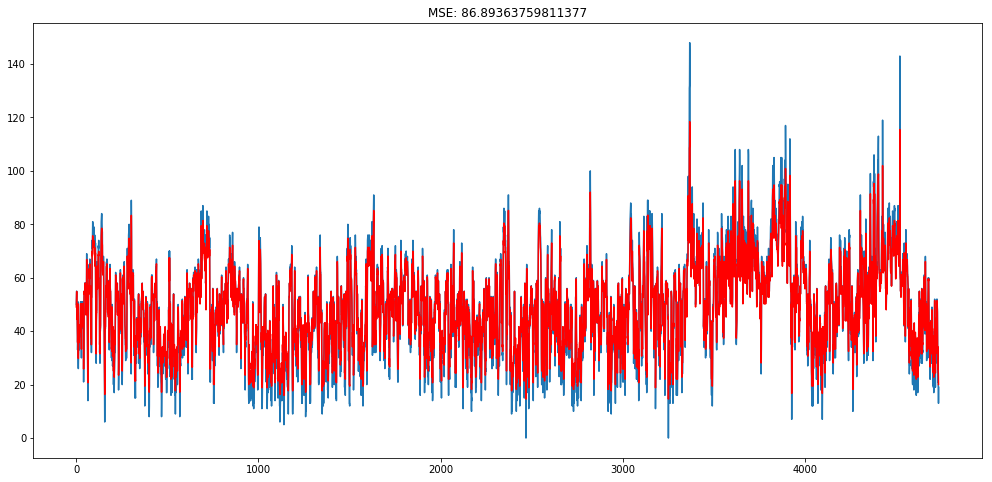

In [13]:
plt.figure(figsize=(17,8))
plt.plot(y)
plt.plot(predictions, color='red')
plt.title("MSE: {}".format(error))



Let's zoom in to the last 200 predictions to get a better look

Text(0.5, 1.0, 'MSE: 86.89363759811377')

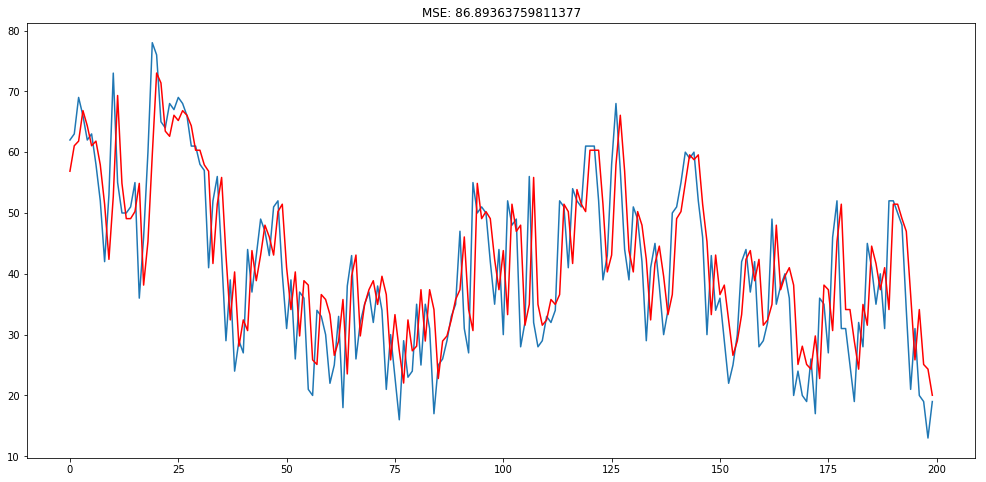

In [15]:
plt.figure(figsize=(17,8))
plt.plot(y[-200:])
plt.plot(predictions[-200:], color='red')
plt.title("MSE: {}".format(error))

## Evaluate model that incorporates weather data

In [27]:
features=7

# prepare data into supervised learning problem by separating X and y
y = df["Mannerheimintie"].shift(-1).values
y = y[~np.isnan(y)]
y = y.reshape(-1, 1)

X = df.drop("Timestamp", axis=1)
X.drop(X.tail(1).index,inplace=True) 
X = X.values

scaler_X = RobustScaler()
X = scaler_X.fit_transform(X)
scaler_y = RobustScaler()
y = scaler_y.fit_transform(y)
eval_generator = TimeseriesGenerator(X, y, length=2, batch_size=64)

[[ 0.11538462]
 [ 0.19230769]
 [-0.19230769]
 ...
 [-1.19230769]
 [-1.42307692]
 [-1.19230769]]


In [18]:
model = load_model("models/lstm-weather-data-look-back-1.h5")

In [31]:
yhat = model.predict_generator(eval_generator)
predictions = scaler_y.inverse_transform(yhat)
y1 = scaler_y.inverse_transform(y)
error = mean_squared_error(y1[:len(yhat)], predictions)

Text(0.5, 1.0, 'MSE: 57.89694105023749')

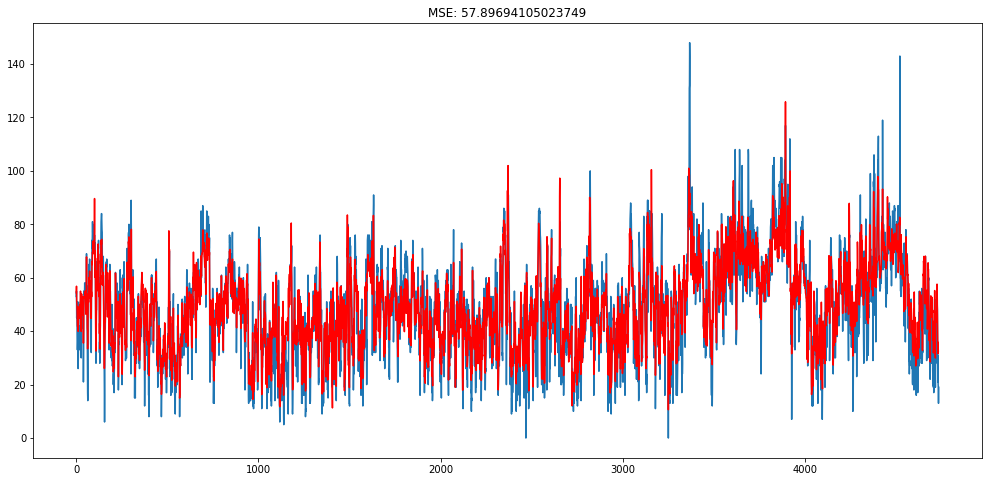

In [33]:
plt.figure(figsize=(17,8))
plt.plot(y1)
plt.plot(predictions, color='red')
plt.title("MSE: {}".format(error))

Text(0.5, 1.0, 'MSE: 57.89694105023749')

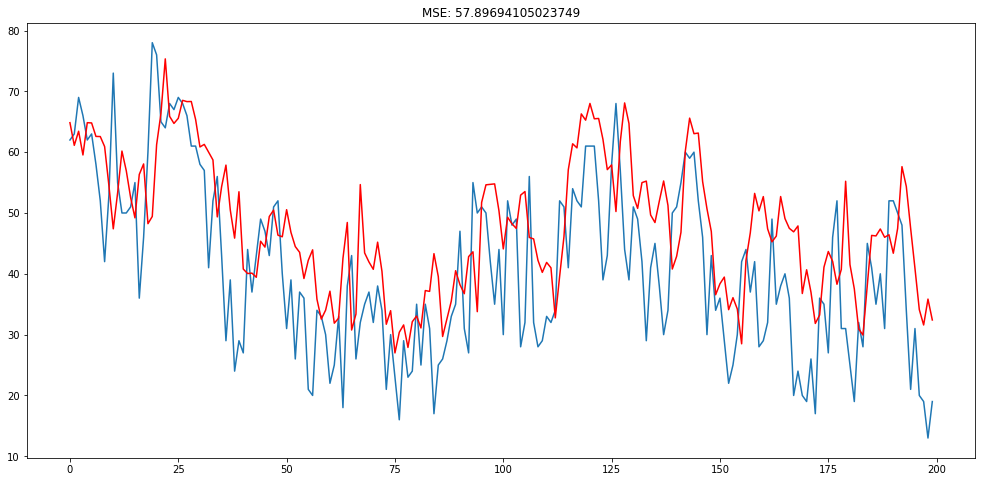

In [35]:
plt.figure(figsize=(17,8))
plt.plot(y1[-200:])
plt.plot(predictions[-200:], color='red')
plt.title("MSE: {}".format(error))

## Summary

Both models perform suprisingly well with the evaluation data with MSE of 87 and 58. It looks like that the model with weather data generalizes a bit better that the model without weather data. Even though model without weather data was much more accurate during training phase.